In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

## Data preparation

In [2]:
data = pd.read_csv('ipl_prog_data_2022.csv')
data

,season,team,matches,wins,points,nrr,position,nrr_rank,longest_winning_streak,longest_winless_streak,unique_match_winners,unique_match_winners_rank,is_top_4,is_top_2,is_champion
0,2011,Chennai Super Kings,1,1,2,0.100,5,5,1,0,1,1,1,1,1.0
1,2011,Chennai Super Kings,2,1,2,-0.258,6,6,1,1,1,4,1,1,1.0
2,2011,Chennai Super Kings,3,2,4,0.181,5,6,1,1,2,1,1,1,1.0
3,2011,Chennai Super Kings,4,2,4,-0.097,6,6,1,1,2,3,1,1,1.0
4,2011,Chennai Super Kings,5,2,4,-0.157,8,7,1,2,2,3,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,2022,Sunrisers Hyderabad,10,5,10,0.325,5,4,5,3,5,3,0,0,NaN
1172,2022,Sunrisers Hyderabad,11,5,10,-0.031,6,6,5,4,5,3,0,0,NaN
1173,2022,Sunrisers Hyderabad,12,5,10,-0.270,8,9,5,5,5,4,0,0,NaN
1174,2022,Sunrisers Hyderabad,13,6,12,-0.230,8,8,5,5,5,5,0,0,NaN


In [3]:
num_teams_new = 10
matches_per_team = 14
num_samples_new = matches_per_team * num_teams_new

X, y = data.iloc[:-num_samples_new, 2:-3], data.iloc[:-num_samples_new, -1]

In [4]:
test_seasons = 3
teams_per_season = 8
test_size = test_seasons * teams_per_season * matches_per_team

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)

In [5]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.groupby(y_train.index // matches_per_team).apply(lambda x: x.mean()).reset_index(drop = True)
y_test = y_test.groupby(y_test.index // matches_per_team).apply(lambda x: x.mean()).reset_index(drop = True)

In [6]:
num_features = X.shape[1]

X_train = X_train.values.reshape((-1, matches_per_team, num_features))
y_train = y_train.values.reshape((-1, 1))

X_test = X_test.values.reshape((-1, matches_per_team, num_features))
y_test = y_test.values.reshape((-1, 1))


## Model training

In [7]:
model = Sequential()
model.add(Input(shape = (matches_per_team, num_features)))
model.add(LSTM(32, recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), 
              metrics = [tf.keras.metrics.AUC()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5504      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
num_epochs = 250
batch_size = 8
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1, 
                                                          restore_best_weights = True)
class_weight = {
    0: 1,
    1: y_train[y_train == 0].size / y_train[y_train == 1].size
}

In [9]:
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, 
                    class_weight = class_weight, validation_split = 0.2, callbacks = [early_stopping_monitor])

Epoch 1/250
5/5 [==============================] - 1s 134ms/step - loss: 1.5551 - auc: 0.3257 - val_loss: 1.3467 - val_auc: 0.0556
Epoch 2/250
5/5 [==============================] - 1s 124ms/step - loss: 1.5413 - auc: 0.3229 - val_loss: 1.3208 - val_auc: 0.1111
Epoch 3/250
5/5 [==============================] - 1s 125ms/step - loss: 1.5049 - auc: 0.3800 - val_loss: 1.2929 - val_auc: 0.0556
Epoch 4/250
5/5 [==============================] - 1s 160ms/step - loss: 1.5183 - auc: 0.2400 - val_loss: 1.2678 - val_auc: 0.0556
Epoch 5/250
5/5 [==============================] - 1s 136ms/step - loss: 1.4931 - auc: 0.3143 - val_loss: 1.2402 - val_auc: 0.1111
Epoch 6/250
5/5 [==============================] - 1s 126ms/step - loss: 1.4870 - auc: 0.2629 - val_loss: 1.2128 - val_auc: 0.1111
Epoch 7/250
5/5 [==============================] - 1s 126ms/step - loss: 1.4366 - auc: 0.3286 - val_loss: 1.1876 - val_auc: 0.0556
Epoch 8/250
5/5 [==============================] - 1s 126ms/step - loss: 1.4391 - a

## Model evaluation

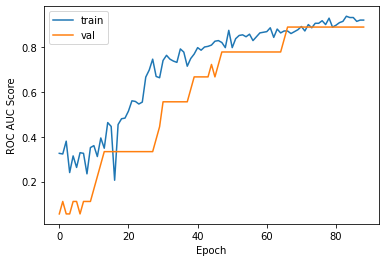

In [10]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.xlabel('Epoch')
plt.ylabel('ROC AUC Score')
plt.legend(['train', 'val'])
plt.show()

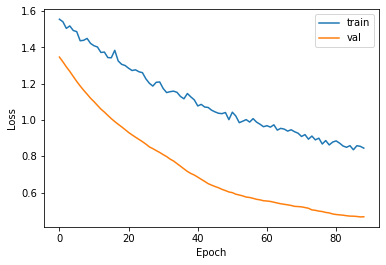

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [12]:
scores = model.evaluate(X_train, y_train, verbose = 0)
scores[1]

0.9261363744735718

In [13]:
scores = model.evaluate(X_test, y_test, verbose = 0)
scores[1]

0.920634925365448

In [14]:
# Make sure that exactly 1 team is predicted as the winner per season
y_pred = model.predict(X_test)
temp = y_pred.reshape(test_seasons, teams_per_season)
y_pred = (temp == temp.max(axis = 1).reshape(test_seasons, 1)).astype(int).reshape(-1, 1)

In [15]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        21
         1.0       0.67      0.67      0.67         3

    accuracy                           0.92        24
   macro avg       0.81      0.81      0.81        24
weighted avg       0.92      0.92      0.92        24



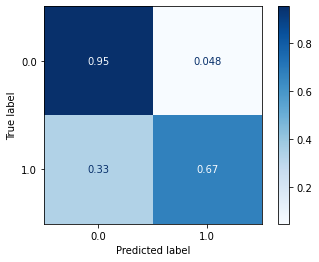

In [16]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', normalize = 'true')
plt.show()

In [17]:
# Inspect test set predictions
y_pred = pd.DataFrame(model.predict(X_test), columns = ['win_prob'])
y_test = pd.DataFrame(y_test, columns = ['result']).astype(int)

temp = data.iloc[-(num_samples_new + test_size):-num_samples_new][['season', 'team']].groupby(
    ['season', 'team'], as_index = False
).apply(lambda x: x.iloc[0])

temp = pd.concat([temp, y_pred, y_test], axis = 1)
temp = temp.groupby('season').apply(
    lambda x: x.sort_values('win_prob', ascending = False).set_index(x.reset_index().index + 1)
)[['team', 'win_prob', 'result']]
temp

team  win_prob  result
season                                                 
2019   1               Mumbai Indians  0.676381       1
       2          Chennai Super Kings  0.628530       0
       3               Delhi Capitals  0.584779       0
       4          Sunrisers Hyderabad  0.379847       0
       5        Kolkata Knight Riders  0.252001       0
       6                 Punjab Kings  0.244507       0
       7             Rajasthan Royals  0.191535       0
       8  Royal Challengers Bangalore  0.148046       0
2020   1               Mumbai Indians  0.604633       1
       2               Delhi Capitals  0.522148       0
       3          Sunrisers Hyderabad  0.468614       0
       4  Royal Challengers Bangalore  0.420817       0
       5        Kolkata Knight Riders  0.323665       0
       6                 Punjab Kings  0.270017       0
       7          Chennai Super Kings  0.182382       0
       8             Rajasthan Royals  0.177613       0
2021   1               Delhi Capitals  0.657162       0
       2          Chennai Super Kings  0.566935       1
       3  Royal Challengers Bangalore  0.543091       0
       4        Kolkata Knight Riders  0.429551       0
       5               Mumbai Indians  0.289383       0
       6                 Punjab Kings  0.213771       0
       7             Rajasthan Royals  0.154251       0
       8          Sunrisers Hyderabad  0.119810       0

## Model testing

In [18]:
y = y.groupby(y.index // matches_per_team).apply(lambda x: x.mean()).reset_index(drop = True)

X = X.values.reshape((-1, matches_per_team, num_features))
y = y.values.reshape((-1, 1))

In [19]:
class_weight = {
    0: 1,
    1: y[y == 0].size / y[y == 1].size
}

In [20]:
early_stopped_epochs = early_stopping_monitor.stopped_epoch + 1
patience = early_stopping_monitor.patience

final_model_epochs = num_epochs if (early_stopped_epochs == 1) else (early_stopped_epochs - patience)

In [21]:
history = model.fit(X, y, epochs = final_model_epochs, batch_size = batch_size, class_weight = class_weight, 
                    verbose = 0)

In [22]:
scores = model.evaluate(X, y, verbose = 0)
scores[1]

0.9726496338844299

In [23]:
X_new = data.iloc[-num_samples_new:, 2:-3]
X_new = X_new.values.reshape((-1, matches_per_team, num_features))

In [24]:
predictions = model.predict(X_new)

In [25]:
win_threshold = temp[temp.result == 1].win_prob.min()

In [26]:
def stylize(styler):
    styler.set_table_styles([{
        'selector': 'th, td',
        'props': [('text-align', 'left')]
    },
    {
        'selector': 'th:nth-child(1), td:nth-child(1)',
        'props': [('text-align', 'center')]
    }])
    
    c = 0.8
    e = 0.93
    f = 1.0
    
    intermediate = (expected_outcome.win_prob.min() + win_threshold) / 2
    
    cdict = {
        'red': ((0.0,  f, f),
                (intermediate,  f, f),
                (win_threshold,  f, f),
                (1.0,  c, c)),
        
        'green': ((0.0,  c, c),
                  (intermediate,  e, e),
                  (win_threshold,  f, f),
                  (1.0,  f, f)),

        'blue': ((0.0,  c, c),
                 (intermediate,  c, c),
                 (win_threshold,  c, c),
                 (1.0,  c, c))
    }
    cmap = LinearSegmentedColormap('custom_cmap', cdict)

    styler.background_gradient(cmap = cmap, gmap = expected_outcome.win_prob)
    return styler

In [27]:
expected_outcome = pd.DataFrame({
    'team': list(data.iloc[-num_samples_new:].team.unique()),
    'win_prob': list(predictions.ravel())
})

expected_outcome.sort_values('win_prob', ascending = False, inplace = True, ignore_index = True)
expected_outcome.index += 1
expected_outcome = expected_outcome.rename_axis('#').reset_index()
expected_outcome.style.hide_index().pipe(stylize)

#,team,win_prob
1,Gujarat Titans,0.898721
2,Lucknow Super Giants,0.713661
3,Rajasthan Royals,0.427535
4,Royal Challengers Bangalore,0.098057
5,Mumbai Indians,0.079828
6,Punjab Kings,0.075863
7,Delhi Capitals,0.060923
8,Sunrisers Hyderabad,0.053967
9,Chennai Super Kings,0.051411
10,Kolkata Knight Riders,0.035944
